In [1]:
from abc import ABC, abstractmethod
from datetime import datetime
from collections import defaultdict
from timeit import default_timer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import random

In [2]:
class TimeConstraint:

    def __init__(self, end_dt, start_dt=None):
        """
        When end_dt is only given, system will have a max time constraint only.

        When end_dt and start_dt are given, system will have beginning end ending boundary.

        :param end_dt: The maximum limit of the time constraint.
        :param start_dt: The minimum limit of the time constraint.
            Always set start_dt to None if you change the object from time_bin to max_limit.
        """
        self.end_dt = end_dt
        self.start_dt = start_dt

    def is_valid_time_bin(self) -> bool:
        """
        Check whether this TimeConstraint object represents a valid time bin.
        """
        if self.is_time_bin() and (self._end_dt > self._start_dt):
            return True
        return False

    def is_valid_max_limit(self) -> bool:
        """
        Check whether this TimeConstraint represents a valid max time limit.
        """
        if (self._end_dt is not None) and (self._start_dt is None):
            return True

    def is_time_bin(self) -> bool:
        if (self._start_dt is not None) and (self._end_dt is not None):
            return True
        return False

    # Comparing TimeConstraints

    def __eq__(self, other):
        if other is None:
            return False
        return self._start_dt == other.start_dt and self._end_dt == other.end_dt

    def __ne__(self, other):
        if other is None:
            return False
        return self._start_dt != other.start_dt or self._end_dt != other.end_dt

    # Properties

    @property
    def end_dt(self):
        return self._end_dt

    @end_dt.setter
    def end_dt(self, value):
        self._end_dt = value

    @property
    def start_dt(self):
        return self._start_dt

    @start_dt.setter
    def start_dt(self, value):
        self._start_dt = value

    # Printing TimeConstraints

    def __repr__(self):
        return f"(start = {self._start_dt}, end= {self._end_dt})"

    def __str__(self):
        return f"(start = {self._start_dt}, end= {self._end_dt})"


In [3]:
class Cache:

    def __init__(self,
                 is_ratings_cached=False,
                 ratings=None,
                 is_movies_cached=False,
                 movies=None,
                 is_movie_ratings_cached=False,
                 movie_ratings=None,
                 is_user_movie_matrix_cached=False,
                 user_movie_matrix=None,
                 is_user_correlations_cached=False,
                 user_correlations=None,
                 min_common_elements=5,
                 use_avg_ratings_cache=True):
        """ Cached data is only valid when the boolean specifier is True """

        # 30% performance
        self.is_ratings_cached = is_ratings_cached
        self.ratings = ratings

        # 7 fold performance gain on 'movie' related queries
        self.is_movies_cached = is_movies_cached
        self.movies = movies

        self.is_movie_ratings_cached = is_movie_ratings_cached
        self.movie_ratings = movie_ratings

        self.is_user_movie_matrix_cached = is_user_movie_matrix_cached
        self.user_movie_matrix = user_movie_matrix

        self.is_user_correlations_cached = is_user_correlations_cached
        self.user_correlations = user_correlations

        self.min_common_elements = min_common_elements

        # if use avg ratings cache, on average 10 fold performance gain
        self.use_avg_ratings_cache = use_avg_ratings_cache
        if self.use_avg_ratings_cache:
            self.avg_user_ratings = self.create_user_avg_rating_cache()
        else:
            self.avg_user_ratings = None

    def create_user_avg_rating_cache(self):
        if self.is_ratings_cached:
            data = self.ratings
        else:
            data = self.movie_ratings
        return data.groupby('user_id')[['rating']].mean()

    def get_user_corrs(self, min_common_elements, time_constraint=None):
        """
        If cached returns the cache, else none
        :param min_common_elements: min common element in between users in order them to become neighbours
        :param time_constraint: used in temporal caches only, None in this context
        :return: user correlation matrix if cache found, else None
        """
        if self.is_user_correlations_cached:
            if self.min_common_elements == min_common_elements:
                return self.user_correlations
        return None

    # Properties
    @property
    def ratings(self):
        return self._ratings

    @ratings.setter
    def ratings(self, value):
        self._ratings = value

    @property
    def movies(self):
        return self._movies

    @movies.setter
    def movies(self, value):
        self._movies = value

    @property
    def movie_ratings(self):
        return self._movie_ratings

    @movie_ratings.setter
    def movie_ratings(self, value):
        self._movie_ratings = value

    @property
    def user_movie_matrix(self):
        return self._user_movie_matrix

    @user_movie_matrix.setter
    def user_movie_matrix(self, value):
        self._user_movie_matrix = value

    @property
    def user_correlations(self):
        return self._user_correlations

    @user_correlations.setter
    def user_correlations(self, value):
        self._user_correlations = value

    @property
    def min_common_elements(self):
        return self._min_common_elements

    @min_common_elements.setter
    def min_common_elements(self, value):
        self._min_common_elements = value


class TemporalCache(Cache):

    def __init__(self,
                 time_constraint: TimeConstraint,
                 is_ratings_cached=False,
                 ratings=None,
                 is_movies_cached=False,
                 movies=None,
                 is_movie_ratings_cached=False,
                 movie_ratings=None,
                 is_user_movie_matrix_cached=False,
                 user_movie_matrix=None,
                 is_user_correlations_cached=False,
                 user_correlations=None,
                 min_common_elements=5,
                 use_avg_ratings_cache=True,
                 use_bulk_corr_cache=True):

        super().__init__(is_ratings_cached=is_ratings_cached,
                         ratings=ratings,
                         is_movies_cached=is_movies_cached,
                         movies=movies,
                         is_movie_ratings_cached=is_movie_ratings_cached,
                         movie_ratings=movie_ratings,
                         is_user_movie_matrix_cached=is_user_movie_matrix_cached,
                         user_movie_matrix=user_movie_matrix,
                         is_user_correlations_cached=is_user_correlations_cached,
                         user_correlations=user_correlations,
                         min_common_elements=min_common_elements,
                         use_avg_ratings_cache=use_avg_ratings_cache)

        self.time_constraint = time_constraint
        self.use_bulk_corr_cache = use_bulk_corr_cache
        self.user_corrs_in_bulk = None

    def is_temporal_cache_valid(self):
        # No TimeConstraint, valid
        if self._time_constraint is None:
            return True
        # Bin TimeConstraint or Max Limit TimeConstraint, valid
        if self._time_constraint.is_valid_time_bin() or self._time_constraint.is_valid_max_limit():
            return True
        # Else, Not Valid
        return False

    def get_user_corrs_from_bulk(self, min_common_elements, time_constraint, bin_size):
        if ((self.user_corrs_in_bulk is None) or (self.user_corrs_in_bulk is None)
                or (time_constraint is None) or self.min_common_elements != min_common_elements):
            return None

        if time_constraint.is_valid_max_limit():
            return self.user_corrs_in_bulk.get(time_constraint.end_dt.year)

        if bin_size == -1:
            return None

        bins = self.user_corrs_in_bulk.get(bin_size)
        if bins is not None:
            return bins.get(time_constraint.start_dt.year)

    def get_user_corrs(self, min_common_elements, time_constraint=None):
        """
        If cached returns the cache, else none

        :param min_common_elements: min common element in between users in order them to become neighbours
        :param time_constraint: time constraint on user correlations
        :return: user correlation matrix if cache found, else None
        """
        if self.is_user_correlations_cached:
            if self.time_constraint == time_constraint and self.min_common_elements == min_common_elements:
                return self.user_correlations
        return None

    def set_user_corrs(self, user_corrs, min_common_elements, time_constraint):
        # Only set when caching is open for user_correlations
        if self.is_user_correlations_cached:
            self._time_constraint = time_constraint
            self.min_common_elements = min_common_elements
            self.user_correlations = user_corrs

    @property
    def time_constraint(self):
        return self._time_constraint

    @time_constraint.setter
    def time_constraint(self, value):
        self._time_constraint = value


In [4]:
class Accuracy:

    @staticmethod
    def rmse(predictions) -> float:
        if type(predictions) is pd.DataFrame:
            number_of_predictions = 0
            sum_of_square_differences = 0.0
            for row in predictions.itertuples(index=False):
                # row[1] : actual rating, row[0] : prediction
                prediction = row[0]
                if prediction != 0:
                    sum_of_square_differences += (row[1] - prediction) ** 2
                    number_of_predictions += 1
            return sum_of_square_differences / number_of_predictions if number_of_predictions != 0 else 0
        elif type(predictions) is list:
            number_of_predictions = 0
            sum_of_square_differences = 0.0
            for prediction, actual in predictions:
                if prediction != 0:
                    sum_of_square_differences += (actual - prediction) ** 2
                    number_of_predictions += 1
            return sum_of_square_differences / number_of_predictions if number_of_predictions != 0 else 0
        return 0

In [5]:
class Dataset(ABC):
    @staticmethod
    @abstractmethod
    def load():
        """ Every subclass must provide static load method"""
        pass


class MovieLensDataset(Dataset):
    def __init__(self,
                 ratings_col_names=('user_id', 'item_id', 'rating', 'timestamp'),
                 ratings_path=r'C:\Users\Yukawa\datasets\ml-latest-small\ratings.csv',
                 movies_col_names=('item_id', 'title', 'genres'),
                 movies_path=r'C:\Users\Yukawa\datasets\ml-latest-small\movies.csv',
                 is_ratings_cached=True,
                 is_movies_cached=True):
        Dataset.__init__(self)
        self.is_ratings_cached = is_ratings_cached
        self.is_movies_cached = is_movies_cached
        self.ratings = MovieLensDataset.load_ratings(ratings_path,
                                                     ratings_col_names) if self.is_ratings_cached else None
        self.movies = MovieLensDataset.load_movies(movies_path,
                                                   movies_col_names) if self.is_movies_cached else None

    @staticmethod
    def load_movies(movies_path,
                    movies_col_names=('item_id', 'title', 'genres')):
        if not os.path.isfile(movies_path) or not movies_col_names:
            return None

        # read movies
        movies = pd.read_csv(movies_path, sep=',', header=1, names=movies_col_names)

        # Extract Movie Year
        movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
        movies.year = pd.to_datetime(movies.year, format='%Y')
        movies.year = movies.year.dt.year  # As there are some NaN years, resulting type will be float (decimals)

        # Remove year part from the title
        movies.title = movies.title.str[:-7]

        return movies

    @staticmethod
    def load_ratings(ratings_path,
                     ratings_col_names=('user_id', 'item_id', 'rating', 'timestamp')):
        if not os.path.isfile(ratings_path) or not ratings_col_names:
            return None

        # read ratings
        ratings = pd.read_csv(ratings_path, sep=',', header=1, names=ratings_col_names)

        # Convert timestamp into readable format
        ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s', origin='unix')

        return ratings

    @staticmethod
    def create_movie_ratings(ratings, movies):
        return pd.merge(ratings, movies, on='item_id')

    @staticmethod
    def load(ratings_col_names=('user_id', 'item_id', 'rating', 'timestamp'),
             ratings_path=r'C:\Users\Yukawa\datasets\ml-latest-small\ratings.csv',
             movies_col_names=('item_id', 'title', 'genres'),
             movies_path=r'C:\Users\Yukawa\datasets\ml-latest-small\movies.csv'
             ):
        # Load movies
        movies = MovieLensDataset.load_movies(movies_path=movies_path, movies_col_names=movies_col_names)
        # Load ratings
        ratings = MovieLensDataset.load_ratings(ratings_path=ratings_path, ratings_col_names=ratings_col_names)

        # Merge the ratings and movies
        movie_ratings = pd.merge(ratings, movies, on='item_id')

        return movie_ratings

In [6]:
class TemporalPearson:

    def __init__(self, cache: TemporalCache, time_constraint: TimeConstraint = None, min_common_elements: int = 5):
        self.time_constraint = time_constraint
        self.cache = cache
        self.min_common_elements = min_common_elements
        #from .trainset import TrainsetUser, TrainsetMovie
        self.trainset_user = TrainsetUser(cache=self.cache)
        self.trainset_movie = TrainsetMovie(cache=self.cache)

    def mean_centered_pearson(self, user_id, movie_id, k_neighbours: pd.DataFrame) -> float:
        """
        Calculate Mean Centered Prediction

        :param user_id: user of interest
        :param movie_id: the movie's rating is the one we we want to predict
        :param k_neighbours: k nearest neighbours in DataFrame where index user_id, column correlation in between.
        :return: Prediction rating
        """
        # If a movie with movie_id not exists, predict 0
        if self.trainset_movie.get_movie(movie_id=movie_id).empty:
            return 0

        if k_neighbours is None or k_neighbours.empty:
            return 0

        user_avg_rating = self.trainset_user.get_user_avg(user_id=user_id)

        weighted_sum = 0.0
        sum_of_weights = 0.0
        for neighbour_id, data in k_neighbours.iterrows():
            # Get each neighbour's correlation 'user_id' and her rating to 'movie_id'
            neighbour_corr = data['correlation']
            neighbour_rating = self.trainset_movie.get_movie_rating(movie_id=movie_id, user_id=neighbour_id)
            # If the neighbour doesnt give rating to the movie_id, pass this around of the loop
            if neighbour_rating == 0:
                continue
            neighbour_avg_rating = self.trainset_user.get_user_avg(user_id=neighbour_id)
            neighbour_mean_centered_rating = neighbour_rating - neighbour_avg_rating
            # Calculate Weighted sum and sum of weights
            weighted_sum += neighbour_mean_centered_rating * neighbour_corr
            sum_of_weights += neighbour_corr

        # Predict
        if sum_of_weights != 0:
            prediction_rating = user_avg_rating + (weighted_sum / sum_of_weights)
        else:
            prediction_rating = 0  # In this case, none of the neighbours have given rating to 'the movie'

        return prediction_rating

    def get_corr_matrix(self, bin_size=-1):
        user_corrs = None
        # if valid cache found, try to get user corrs from there
        if self.cache.is_temporal_cache_valid():
            # First check user-correlations
            user_corrs = self.cache.get_user_corrs(self.min_common_elements, self.time_constraint)
            if user_corrs is not None:
                return user_corrs
            # Then check bulk-user-correlations
            user_corrs = self.cache.get_user_corrs_from_bulk(time_constraint=self.time_constraint,
                                                             min_common_elements=self.min_common_elements,
                                                             bin_size=bin_size)
            if user_corrs is not None:
                return user_corrs

        # here, if cache not found or no cache match

        # Create user correlations
        user_corrs = TemporalPearson.create_user_corrs(movie_ratings=self.cache.movie_ratings,
                                                       time_constraint=self.time_constraint,
                                                       min_common_elements=self.min_common_elements)
        # Cache the user_corrs
        self.cache.set_user_corrs(user_corrs=user_corrs,
                                  min_common_elements=self.min_common_elements,
                                  time_constraint=self.time_constraint)

        return user_corrs

    @staticmethod
    def create_user_corrs(movie_ratings, time_constraint: TimeConstraint, min_common_elements):
        # by default movie_ratings is for no time constraint
        # with these controls change the time constraint of the movie_ratings
        if time_constraint is not None:
            if time_constraint.is_valid_max_limit():
                movie_ratings = movie_ratings[movie_ratings.timestamp < time_constraint.end_dt]
            elif time_constraint.is_valid_time_bin():
                movie_ratings = movie_ratings[(movie_ratings.timestamp >= time_constraint.start_dt)
                                              & (movie_ratings.timestamp < time_constraint.end_dt)]

        user_movie_matrix = movie_ratings.pivot_table(index='title', columns='user_id', values='rating')
        return user_movie_matrix.corr(method="pearson", min_periods=min_common_elements)

    def cache_user_corrs_in_bulk_for_max_limit(self, time_constraint: TimeConstraint, min_year, max_year):
        """
        Cache user correlations by changing year of the time_constraint
        for each year in between min_year and max_year(not included)

        :param time_constraint: time_constraint apply
        :param min_year: start of the range
        :param max_year: end of the range
        """

        if self.cache.use_bulk_corr_cache:
            if time_constraint is not None and time_constraint.is_valid_max_limit():
                self.cache.user_corrs_in_bulk = dict()
                for year in range(min_year, max_year):
                    time_constraint.end_dt = time_constraint.end_dt.replace(year=year)
                    corrs = TemporalPearson.create_user_corrs(self.cache.movie_ratings, time_constraint,
                                                              self.min_common_elements)
                    self.cache.user_corrs_in_bulk[year] = corrs
            else:
                raise Exception("Trying to cache user correlations in bulk for max_limit "
                                "but start time is not max_limit!")
        else:
            raise Exception("Trying to create bulk corr cache when use_bulk_corr_cache is False")

    def cache_user_corrs_in_bulk_for_time_bins(self, time_constraint: TimeConstraint, min_year, max_year,
                                               min_time_bin_size=2, max_time_bin_size=10):
        if self.cache.use_bulk_corr_cache:
            if time_constraint is not None and time_constraint.is_valid_time_bin():
                del self.cache.user_corrs_in_bulk    # invalidate old cache
                self.cache.user_corrs_in_bulk = dict()
                for time_bin_size in range(min_time_bin_size, max_time_bin_size):
                    self.cache.user_corrs_in_bulk[time_bin_size] = dict()
                    for shift in range(0, time_bin_size):
                        curr_year = min_year + shift
                        while (curr_year + time_bin_size) < max_year:
                            time_constraint = TimeConstraint(start_dt=datetime(curr_year, 1, 1),
                                                             end_dt=datetime(curr_year + time_bin_size, 1, 1))
                            corrs = TemporalPearson.create_user_corrs(self.cache.movie_ratings,
                                                                      time_constraint,
                                                                      self.min_common_elements)
                            self.cache.user_corrs_in_bulk[time_bin_size][curr_year] = corrs
                            curr_year += time_bin_size
        else:
            raise Exception("Trying to create bulk corr cache when use_bulk_corr_cache is False")

    @property
    def time_constraint(self):
        return self._time_constraint

    @time_constraint.setter
    def time_constraint(self, value):
        self._time_constraint = value


In [7]:
class TrainsetUser:

    def __init__(self, cache: Cache):
        """
        :param cache: Input cache must have movie_ratings not None !
        """
        self.cache = cache

        if not self.cache.is_movie_ratings_cached:
            raise Exception("'movie_ratings' has not been cached !")

    def get_users(self):
        """
        Get list of unique 'user_id's

        Since MovieLens Have 'user_id's from 0 to 610 without any missing user, for now sending that directly
        Uncomment the other lines later

        :return: the ids of the users found in movie_ratings
        """
        #
        # if self.cache.is_ratings_cached:
        #     data = self.cache.ratings
        # else:
        #     data = self.cache.movie_ratings
        #
        # return pd.unique(data['user_id'])
        return range(0, 611)

    def get_active_users(self, n=10) -> pd.DataFrame:
        """
        Get Users in sorted order where the first one is the one who has given most ratings.

        :param n: Number of users to retrieve.
        :return: user DataFrame with index of 'user_id' and columns of ['mean_rating', 'No_of_ratings'] .
        """

        if self.cache.is_ratings_cached:                         # 30% faster than other choice
            data = self.cache.ratings
        else:
            data = self.cache.movie_ratings

        active_users = pd.DataFrame(data.groupby('user_id')['rating'].mean())
        active_users['No_of_ratings'] = pd.DataFrame(data.groupby('user_id')['rating'].count())
        active_users.sort_values(by=['No_of_ratings'], ascending=False, inplace=True)
        active_users.columns = ['mean_rating', 'No_of_ratings']
        return active_users.head(n)

    def get_random_users(self, n=1):
        """
        Get list of random n number of 'user_id's

        :param n: Number of random users
        :return: List of random 'user_id's
        """

        return random.choices(population=self.get_users(), k=n)

    def get_user_ratings(self, user_id: int) -> pd.DataFrame:
        """
        Get all the ratings given by of the chosen users

        :param user_id: id of the chosen user
        :return: Ratings given by the 'user_id'
        """
        if self.cache.is_ratings_cached:                         # 2.2x faster than other choice
            data = self.cache.ratings
        else:
            data = self.cache.movie_ratings

        return data.loc[data['user_id'] == user_id]

    def get_user_avg(self, user_id: int):

        if self.cache.use_avg_ratings_cache:
            avg_user_rating = self.cache.avg_user_ratings.loc[user_id]
            return avg_user_rating[0] if not avg_user_rating.empty else 0

        user_ratings = self.get_user_ratings(user_id=user_id)
        return user_ratings.rating.mean() if not user_ratings.empty else 0

    def get_timestamp(self, user_id: int, movie_id: int):
        """
        Get the timestamp of the given rating

        :param user_id: the users whose rating timestamp we are searching
        :param movie_id: id of the movie that the user gave the rating
        :return: if found the datetime object otherwise None
        """

        if self.cache.is_ratings_cached:
            data = self.cache.ratings
        else:
            data = self.cache.movie_ratings

        timestamp = data.loc[(data['user_id'] == user_id) & (data['item_id'] == movie_id)]
        return timestamp.values[0, 3] if not timestamp.empty else None

    def get_first_timestamp(self):
        if self.cache.is_ratings_cached:
            data = self.cache.ratings
        else:
            data = self.cache.movie_ratings
        return data['timestamp'].min()

    def get_user_avg_timestamp(self, user_id: int):
        user_ratings = self.get_user_ratings(user_id=user_id)
        return user_ratings.timestamp.mean() if not user_ratings.empty else 0

    # TODO: Later, create TemporalDatasetUser, and put this method into that one
    def get_user_ratings_at(self, user_id: int, at: datetime) -> pd.DataFrame:
        """
        Get user ratings up until the given datetime
        :param user_id: id of the chosen user
        :param at: only those ratings that are before this date will be taken into account
        :return: Ratings given by the 'user_id' before given datetime
        """

        if self.cache.is_ratings_cached:
            data = self.cache.ratings
        else:
            data = self.cache.movie_ratings

        return data.loc[(data['user_id'] == user_id) & (data.timestamp < at)]

    # TODO: Later, create TemporalDatasetUser, and put this method into that one
    def get_user_avg_at(self, user_id: int, at: datetime):
        user_ratings = self.get_user_ratings_at(user_id, at)
        return user_ratings.rating.mean() if not user_ratings.empty else 0


class TrainsetMovie:

    def __init__(self, cache: Cache):
        """
        :param cache: Input cache must have movie_ratings not None !
        """
        self.cache = cache

        if not self.cache.is_movie_ratings_cached:
            raise Exception("'movie_ratings' has not been cached !")

    def get_movie(self, movie_id) -> pd.DataFrame:
        """
        Get Movie Record

        :return: DataFrame which contains the given 'movie_id's details. If not found empty DataFrame .
        """
        if self.cache.is_movies_cached:
            return self.cache.movies.loc[self.cache.movies['item_id'] == movie_id]
        return self.cache.movie_ratings.loc[self.cache.movie_ratings['item_id'] == movie_id]

    def get_movies(self):
        """
        Get list of unique 'item_id's or in other words the movies.

        :return: List of movie ids
        """

        if self.cache.is_movies_cached:
            return self.cache.movies['item_id'].values.tolist()

        return pd.unique(self.cache.movie_ratings['item_id'])

    def get_random_movies(self, n=10):
        """
        Get list of random n number of 'item_id's or in other words the movies

        :param n: Number of random movies
        :return: List of random 'movie_id's
        """
        return random.choices(population=self.get_movies(), k=n)

    def get_movies_watched(self, user_id: int, time_constraint: TimeConstraint = None) -> pd.DataFrame:
        """
        Get all the movies watched by the chosen user.

        :param user_id: the user that we want to get the movies he-she has watched.
        :param time_constraint: type of the time constraint.
        :return: DataFrame of all movies watched with 'item_id', 'rating' columns
        """

        movie_ratings = self.cache.movie_ratings

        if time_constraint is None:
            return movie_ratings.loc[(movie_ratings['user_id'] == user_id)][['item_id', 'rating']]

        if time_constraint.is_valid_max_limit():
            return movie_ratings.loc[(movie_ratings['user_id'] == user_id)
                                     & (movie_ratings.timestamp < time_constraint.end_dt)][['item_id', 'rating']]
        elif time_constraint.is_valid_time_bin():
            return movie_ratings.loc[(movie_ratings['user_id'] == user_id)
                                     & (movie_ratings.timestamp >= time_constraint.start_dt)
                                     & (movie_ratings.timestamp < time_constraint.end_dt)][['item_id', 'rating']]
        raise Exception("Undefined time_constraint is given!")

    def get_movie_rating(self, movie_id: int, user_id: int) -> int:
        """
        Get the movie rating taken by the chosen user

        :param movie_id: the movie chosen movie's id
        :param user_id: id of the chosen user
        :return: Rating given by user. If not found, returns 0
        """

        if self.cache.is_ratings_cached:
            data = self.cache.ratings
        else:
            data = self.cache.movie_ratings

        movie_rating = data.loc[(data['user_id'] == user_id) & (data['item_id'] == movie_id)]
        return movie_rating.values[0, 2] if not movie_rating.empty else 0

    def get_random_movie_watched(self, user_id: int) -> int:
        """
        Get random movie id watched.

        :param user_id: User of interest
        :return:  movie_id or item_id of the random movie watched by the user.
                  In case non-valid user_id supplied then returns 0
        """
        movies_watched = self.get_movies_watched(user_id=user_id)
        return random.choice(movies_watched['item_id'].values.tolist()) if not movies_watched.empty else 0

    def get_random_movies_watched(self, user_id: int, n=2) -> pd.DataFrame:
        """
        Get random n movies watched by the user. Only use when n > 2

        Use get_random_movie_watched if n=1 since that one 2 fold faster.

        :param user_id: the user of interest
        :param n: number of random movies to get
        :return: DataFrame of movies, if none found then empty DataFrame
        """
        movies_watched = self.get_movies_watched(user_id=user_id)
        return random.choices(population=movies_watched['item_id'].values.tolist(),
                              k=n) if not movies_watched.empty else movies_watched

    def get_random_movie_per_user(self, user_id_list):
        """
        Get random movie for each user given in the 'user_id_list'

        :param user_id_list: List of valid user_ids
        :return: List of (user_id, movie_id) tuples
                where each movie_id is randomly chosen from watched movies of the user_id .
                In case any one of the user_id's supplies invalid, then the movie_id will be 0 for that user.
        """
        user_movie_list = list()
        for user_id in user_id_list:
            user_movie_list.append((user_id, self.get_random_movie_watched(user_id=user_id)))
        return user_movie_list


class Trainset:
    def __init__(self, cache: TemporalCache, min_common_elements: int = 5):
        self.cache = cache
        self.min_common_elements = min_common_elements
        self.similarity = TemporalPearson(time_constraint=None, cache=self.cache)

        if not self.cache.is_movie_ratings_cached:
            raise Exception("'movie_ratings' has not been cached !")

        self.trainset_movie = TrainsetMovie(cache=cache)
        self.trainset_user = TrainsetUser(cache=cache)

        # if caching is allowed, create user correlations cache
        self.similarity.get_corr_matrix()

    def predict_movies_watched(self, user_id, n=10, k=10, time_constraint=None) -> pd.DataFrame:
        """

        :param user_id: user of interest
        :param n: Number of movies to predict
        :param k: k neighbours to take into account
        :param time_constraint: When calculating k neighbours,
                                only those that comply to time_constraints will be taken into account.
        :return: DataFrame of Predictions where columns = ['prediction', 'rating'] index = 'movie_id'
        """
        # Get all movies watched by a user
        movies_watched = self.trainset_movie.get_movies_watched(user_id=user_id)

        if movies_watched.empty:
            return None

        predictions = list()
        number_of_predictions = 0
        for row in movies_watched.itertuples(index=False):
            prediction = self.predict_movie(user_id=user_id, movie_id=row[0],
                                            time_constraint=time_constraint, k=k)
            if number_of_predictions == n:
                break
            predictions.append([prediction, row[1], row[0]])
            number_of_predictions += 1

        predictions_df = pd.DataFrame(predictions, columns=['prediction', 'rating', 'movie_id'])
        predictions_df.movie_id = predictions_df.movie_id.astype(int)
        return predictions_df.set_index('movie_id')

    def predict_movie(self, user_id, movie_id, k=10, time_constraint=None, bin_size=-1):
        prediction = self.similarity.mean_centered_pearson(user_id=user_id,
                                                           movie_id=movie_id,
                                                           k_neighbours=
                                                           self.get_k_neighbours(user_id, k=k,
                                                                                 time_constraint=time_constraint,
                                                                                 bin_size=bin_size)
                                                           )        
        return prediction if prediction <= 5 else 5

    def get_k_neighbours(self, user_id, k=20, time_constraint: TimeConstraint = None, bin_size=-1):
        """
        :param user_id: the user of interest
        :param k: number of neighbours to retrieve
        :param time_constraint: time constraint when choosing neighbours
        :param bin_size: Used when using time_bins, in order to select bin from cache
        :return: Returns the k neighbours and correlations in between them. If no neighbours found, returns None
                 DataFrame which has 'Correlation' column and 'user_id' index.
        """
        self.similarity.time_constraint = time_constraint
        user_corr_matrix = self.similarity.get_corr_matrix(bin_size=bin_size)

        # Exit if matrix is None, no user found in self.cache.movie_ratings, something is wrong
        if user_corr_matrix is None:
            return None

        # Get the chosen 'user_id's correlations
        user_correlations = user_corr_matrix.get(user_id)
        if user_correlations is None:
            return None

        # Drop any null, if found
        user_correlations.dropna(inplace=True)
        # Create A DataFrame from not-null correlations of the 'user_id'
        users_alike = pd.DataFrame(user_correlations)
        # Rename the only column to 'correlation'
        users_alike.columns = ['correlation']

        # Sort the user correlations in descending order
        #     so that first one is the most similar, last one least similar
        users_alike.sort_values(by='correlation', ascending=False, inplace=True)

        # Eliminate Correlation to itself by deleting first row,
        #     since biggest corr is with itself it is in first row
        return users_alike.iloc[1:k+1]


In [8]:

class Evaluator:

    def __init__(self, trainset: Trainset):
        self.trainset = trainset

    def evaluate_best_max_year_in_bulk(self, n,
                                       n_users, n_movies, k=10,
                                       min_year=-1,
                                       max_year=-1) -> dict:
        """
        Evaluate and collect data about best max year constraint which can be put instead of no constraint.

        This method calls 'evaluate_best_max_year_constraint' method 'n' times.
        Takes required precautions for bulk calling.

        :param n: Number of runs that we run the evaluate_best_max_year_constraint() method
        :param n_users: Number of users to check
        :param n_movies: Number of movies per user to check
        :param k: Number of neighbours of each user to take into account when making prediction
        :param min_year: First year to evaluate
        :param max_year: Last year to evaluate
        :return: (no_constrain_rmse_data, best_year_constraint_results)
        """
        if min_year == -1:
            min_year = self.trainset.trainset_user.get_first_timestamp().year

        if max_year == -1:
            max_year = datetime.now().year

        time_constraint = TimeConstraint(end_dt=datetime(year=min_year, month=1, day=1))
        # Create cache if bulk_corr_cache is allowed
        self.trainset.similarity.cache_user_corrs_in_bulk_for_max_limit(time_constraint,
                                                                        min_year=min_year,
                                                                        max_year=max_year)
        
        run_results = dict()
        for i in range(n):
            run_results[i] = self.evaluate_best_max_year_constraint(n_users=n_users, n_movies=n_movies, k=k,
                                                                    min_year=min_year, max_year=max_year,
                                                                    create_cache=False,)

        return run_results

    def evaluate_best_max_year_constraint(self, n_users, n_movies, k,
                                          max_diff=0.1,
                                          min_year=-1, max_year=-1,
                                          create_cache=True) -> defaultdict:
        """
        Evaluate the max_year constraint for evaluate_max_year_constraint method.

        :param max_diff: maximum difference between rmse when no constraint and with given year constraint.
        :param n_users: Number of users to evaluate
        :param n_movies: Number of movies per user to evaluate
        :param k: Number of neighbours of each user to take into account when making prediction
        :param min_year: First year to evaluate
        :param max_year: Last year to evaluate
        :param create_cache: create cache before running. For bulk callers.
        :return: Votes for years where each year got its vote
                 when rmse is less than 'max_diff' in between no constraint and year constraint
        """

        if min_year == -1:
            min_year = self.trainset.trainset_user.get_first_timestamp().year

        if max_year == -1:
            max_year = datetime.now().year

        if n_users > 600:
            user_list = self.trainset.trainset_user.get_users()  # No need to random selection, get all users
        else:
            user_list = self.trainset.trainset_user.get_random_users(n=n_users)  # Select random n users

        # Calculate RMSE With No Constraint
        no_constraint_data = dict()
        for user_id in user_list:
            rmse = Accuracy.rmse(self.trainset.predict_movies_watched(user_id, n_movies, k))
            no_constraint_data[user_id] = rmse

        # # Calculate RMSE With Time Constraint

        # Cache all years before processing
        time_constraint = TimeConstraint(end_dt=datetime(year=min_year, month=1, day=1))
        # Create cache if bulk_corr_cache is allowed
        if create_cache:
            self.trainset.similarity.cache_user_corrs_in_bulk_for_max_limit(time_constraint,
                                                                            min_year=min_year,
                                                                            max_year=max_year)
        # Votes to years is stored inside time_constraint_data
        time_constraint_data = defaultdict(int)
        for year in range(min_year, max_year):
            time_constraint.end_dt = time_constraint.end_dt.replace(year=year)

            for user_id in user_list:
                rmse = Accuracy.rmse(self.trainset.predict_movies_watched(user_id=user_id, n=n_movies, k=k,
                                                                          time_constraint=time_constraint))
                if abs(rmse - no_constraint_data[user_id]) < max_diff:
                    time_constraint_data[year] += 1

        return time_constraint_data

    def evaluate_max_year_constraint(self, n_users, n_movies, k, time_constraint):
        """
        Compare given time_constraint with normal where no constraint exists.

        Time constraint is of type max_year which means the system will be set to a certain year.

        :param n_users: Number of users to evaluate
        :param n_movies: Number of movies per user to evaluate
        :param k: Number of neighbours to take into account when making movie prediction
        :param time_constraint: Time constraint which will be applied.
        :return: DataFrame of results which contains rmse with constraint and no constraint, as well as runtime.
        """
        trainset = self.trainset
        data = list()

        for i in range(n_users):
            # Get Random User
            user_id = random.randint(1, 610)
            # Predict movies for user and record runtime
            st = default_timer()
            rmse = Accuracy.rmse(
                trainset.predict_movies_watched(user_id=user_id, n=n_movies, k=k, time_constraint=None))
            r1 = default_timer() - st
            # Predict movies with time_constraint for user and record runtime
            st = default_timer()
            time_constrained_rmse = Accuracy.rmse(
                trainset.predict_movies_watched(user_id=user_id, n=n_movies, k=k, time_constraint=time_constraint))
            r2 = default_timer() - st
            # Save iteration data
            data.append([user_id, rmse, r1, time_constrained_rmse, r2])

        data = pd.DataFrame(data)
        data.columns = ['user_id', 'rmse', 'runtime1', 'temporal_rmse', 'runtime2']
        data.set_index('user_id', inplace=True)
        return data

    def evaluate_time_bins_in_bulk(self, n, n_users, k=10,
                                   min_year=-1,
                                   max_year=-1,
                                   min_time_bin_size=2, max_time_bin_size=10):
        """
        Evaluate time bins and return the results.

        This method calls 'evaluate_time_bins' method 'n' times. Takes required precautions for bulk calling.

        :param n: Number of runs
        :param n_users: Number of users
        :param k: Number of neighbours will be used when making prediction
        :param min_year: First year to start when taking time bins
        :param max_year: When to stop when taking time bins, last is not included.
        :param min_time_bin_size: Minimum bin size in years
        :param max_time_bin_size: Maximum bin size in years
        :return: Evaluation results
        """
        if min_year == -1:
            min_year = self.trainset.trainset_user.get_first_timestamp().year

        if max_year == -1:
            max_year = datetime.now().year

        # Cache all years before processing
        time_constraint = TimeConstraint(start_dt=datetime(year=min_year, month=1, day=1),
                                         end_dt=datetime(year=max_year, month=1, day=1))
        self.trainset.similarity.cache_user_corrs_in_bulk_for_time_bins(time_constraint,
                                                                        min_year=min_year,
                                                                        max_year=max_year,
                                                                        min_time_bin_size=min_time_bin_size,
                                                                        max_time_bin_size=max_time_bin_size)

        run_results = dict()
        for i in range(n):
            run_results[i] = self.evaluate_time_bins(n_users=n_users, k=k, min_year=min_year, max_year=max_year,
                                                     min_time_bin_size=min_time_bin_size,
                                                     max_time_bin_size=max_time_bin_size,
                                                     create_cache=False)

        return run_results

    def evaluate_time_bins(self, n_users, k, min_year=-1, max_year=-1,
                           min_time_bin_size=2, max_time_bin_size=10,
                           create_cache=True) -> dict:
        """

        :param n_users: Number of users
        :param k: Number of neighbours will be used when making prediction
        :param min_year: First year to start when taking time bins
        :param max_year: When to stop when taking time bins, last is not included.
        :param min_time_bin_size: Minimum bin size in years
        :param max_time_bin_size: Maximum bin size in years
        :param create_cache: Create cache before calling time bins. For bulk callers.
        :return:
        """
        trainset = self.trainset

        if min_year == -1:
            min_year = self.trainset.trainset_user.get_first_timestamp().year

        if max_year == -1:
            max_year = datetime.now().year

        if n_users > 600:
            user_list = trainset.trainset_user.get_users()
        else:
            user_list = trainset.trainset_user.get_random_users(n=n_users)
        user_movie_list = trainset.trainset_movie.get_random_movie_per_user(user_list)
        data = dict()

        result = list()

        if create_cache:
            # Cache all years before processing
            time_constraint = TimeConstraint(start_dt=datetime(year=min_year, month=1, day=1),
                                             end_dt=datetime(year=max_year, month=1, day=1))
            self.trainset.similarity.cache_user_corrs_in_bulk_for_time_bins(time_constraint,
                                                                            min_year=min_year,
                                                                            max_year=max_year,
                                                                            min_time_bin_size=min_time_bin_size,
                                                                            max_time_bin_size=max_time_bin_size)

        # Take each bins where first bin 'min_time_bin_size' years, last one 'max_time_bin_size - 1' years
        for time_bin_size in range(min_time_bin_size, max_time_bin_size):
            # Shift each time_bin starting with 0 years up until (time_bin-1) years
            for shift in range(0, time_bin_size):
                curr_year = min_year + shift
                predictions = list()
                start_time = default_timer()
                # Scan and make predictions for all the time_bins
                while (curr_year + time_bin_size) < max_year:
                    for user_id, movie_id in user_movie_list:
                        p = trainset.predict_movie(user_id=user_id, movie_id=movie_id, k=k,
                                                   time_constraint=TimeConstraint(start_dt=datetime(curr_year, 1, 1),
                                                                                  end_dt=datetime(curr_year+time_bin_size, 1, 1)),
                                                   bin_size=time_bin_size)
                        # if prediction has been done successfully
                        if p != 0:
                            r = trainset.trainset_movie.get_movie_rating(movie_id=movie_id, user_id=user_id)
                            # Append (prediction, actual_rating)
                            predictions.append((p, r))
                    curr_year += time_bin_size
                runtime = default_timer() - start_time
                bin_rmse = Accuracy.rmse(predictions=predictions)
                iteration_results = {"bin_size": time_bin_size,
                                     "start_year": min_year + shift,
                                     "predictions": predictions,
                                     "rmse": bin_rmse,
                                     "runtime": runtime
                                     }
                result.append(iteration_results)

        data['result'] = result
        return data

In [9]:
c = TemporalCache(time_constraint=None, 
                  is_ratings_cached=True,
                  is_movies_cached=True,
                  is_movie_ratings_cached=True,
                  ratings=MovieLensDataset.load_ratings(r'C:\Users\Yukawa\datasets\ml-latest-small\ratings.csv'),
                  movies=MovieLensDataset.load_movies(r'C:\Users\Yukawa\datasets\ml-latest-small\movies.csv'),
                  movie_ratings=MovieLensDataset.load(),
                  is_user_correlations_cached=True,
                  use_bulk_corr_cache=True)

In [10]:
t = Trainset(cache=c, min_common_elements=5)
e = Evaluator(trainset=t)

## Analysis on Best Time Bin Constraint

### Load Saved Results

In [11]:
import pickle

In [12]:
results = list()    # 1400x
for i in range(1,15):
    with open(f"{i}_best_time_bins_bulk_100_with_100_users.data", "rb") as handle:
        result = pickle.loads(handle.read())
        results.append(result)

In [13]:
best_year_results = list()    # 1000x
for i in range(1,11):
    with open(f"{i}_best_max_year_bulk_100_with_10_users.data", "rb") as handle:
        best_year_result = pickle.loads(handle.read())
        best_year_results.append(best_year_result)

### Unpack the best year results

In [14]:
first_bulk_best_year = best_year_results[0]

In [15]:
first_run_best_year = first_bulk_best_year[0]

In [16]:
first_run_best_year

defaultdict(int,
            {1996: 1,
             1997: 2,
             1998: 2,
             1999: 2,
             2000: 1,
             2001: 1,
             2002: 1,
             2003: 2,
             2004: 2,
             2005: 3,
             2006: 3,
             2007: 3,
             2008: 3,
             2009: 2,
             2010: 2,
             2011: 4,
             2012: 4,
             2013: 3,
             2014: 4,
             2015: 4,
             2016: 3,
             2017: 5,
             2018: 9,
             2019: 10})

#### Structure the results

In [17]:
def bulk_best_year_to_run_results(best_year_results):
    best_year_result_list = list()
    for bulk in best_year_results:
        for run in range(100):
            best_year_result_list.append(bulk[run])
    return best_year_result_list

In [18]:
y = bulk_best_year_to_run_results(best_year_results)

In [19]:
best_year_df = pd.DataFrame(y)

In [20]:
best_year_df

,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,3.0,...,2.0,4.0,4.0,3.0,4,4.0,3,5,9,10
1,NaN,1.0,1.0,NaN,1.0,2.0,2.0,3.0,2.0,3.0,...,5.0,5.0,5.0,5.0,5,6.0,9,9,8,10
2,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,...,4.0,4.0,4.0,4.0,4,5.0,7,9,10,10
3,4.0,4.0,5.0,3.0,3.0,7.0,5.0,6.0,5.0,5.0,...,7.0,7.0,6.0,7.0,7,7.0,8,8,8,10
4,4.0,4.0,4.0,4.0,3.0,6.0,5.0,5.0,6.0,5.0,...,6.0,6.0,5.0,6.0,6,6.0,7,10,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.0,4.0,4.0,4.0,3.0,3.0,4.0,4.0,3.0,5.0,...,4.0,4.0,4.0,4.0,5,5.0,6,7,6,10
996,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,5.0,5.0,5.0,5.0,5,6.0,8,8,7,10
997,2.0,2.0,3.0,2.0,3.0,3.0,3.0,4.0,3.0,4.0,...,4.0,5.0,4.0,6.0,6,7.0,8,9,9,10
998,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,4.0,...,4.0,5.0,4.0,6.0,6,6.0,8,8,7,10


### Unpack the result time bin results

In [21]:
# List of saved bulk results, each of which has n=100, n_user=100, min_bin=2, max_bin=10
first_bulk_run = results[0]

In [22]:
# Dictionary of results where key=run_number, values=run_results
first_run_of_bulk_run = first_bulk_run[0]

In [23]:
# CHANGE THIS ONE!
# Dictionary of data where there is only 'result' section.d
run_results = first_run_of_bulk_run['result']

In [24]:
# List of iteration results where each iteration results is a dictionary.
first_iteration_result = run_results[0]

In [25]:
def print_iteration(iteration_result):
    # bin_size, start_year, rmse, runtime and also for future analysis all predictions included.
    print(f"bin_size   -> {iteration_result['bin_size']}")
    print(f"start_year -> {iteration_result['start_year']}")
    print(f"rmse       -> {iteration_result['rmse']}")
    print(f"runtime    -> {iteration_result['runtime']}")
    #print(iteration_result['predictions'])

#### Structure The Results

In [26]:
def list_of_bulk_run_to_run_resuts(results):
    run_data = list()
    for bulk_run_pack in results: # for each bulk run pack
        for i in range(100): # iterate 100 runs
            run = bulk_run_pack[i]
            run_data.append(run['result'])
    return run_data
    
def run_result_to_df(run_results):
    run_results_list = list()
    for iteration in run_results:
        bin_size = iteration['bin_size']
        start = iteration['start_year']
        rmse = calculate_rmse(iteration['predictions'])
        #rmse = iteration['rmse']
        #runtime = iteration['rmse']
        run_results_list.append( (start,bin_size,rmse) )
    return pd.DataFrame(run_results_list, columns=['start_year','bin_size','rmse'])

def from_bulk_list_to_df(results):
    # Create list of runs
    run_data = list()
    for bulk_run_pack in results: # for each bulk run pack
        for i in range(100): # iterate 100 runs
            run = bulk_run_pack[i]
            run_data.append(run['result'])
    #
    run_results_list = list()
    for run in run_data:
        for iteration in run:
            bin_size = iteration['bin_size']
            start = iteration['start_year']
            rmse = calculate_rmse(iteration['predictions'])
            #rmse = iteration['rmse']
            #runtime = iteration['runtime']
            run_results_list.append( (start,bin_size,rmse) )
    return pd.DataFrame(run_results_list, columns=['start_year','bin_size','rmse'])

In [27]:
list_of_run_results = list_of_bulk_run_to_run_resuts(results)

In [28]:
def calculate_rmse(predictions:list)->float:
    number_of_predictions = 0
    sum_of_square_differences = 0.0
    for prediction, actual in predictions:
        if 0 < prediction <= 5 :                                             ########### UPDATE THIS IN REAL ONE
            sum_of_square_differences += (actual - prediction) ** 2
            number_of_predictions += 1
    return sum_of_square_differences / number_of_predictions if number_of_predictions != 0 else 0

In [29]:
calculate_rmse(list_of_run_results[1398][2]['predictions'])

0.605636379537504

In [30]:
# !!!! Negative Predictions exists .s.s.s.s
#list_of_run_results[30][0]['predictions']

# rmse_values = list()
# count = 0
# for run in list_of_run_results:
#     if Accuracy.rmse(run[0]['predictions'])  > 10:
#         print(count)
#     count += 1

In [31]:
run_result_to_df(list_of_run_results[0])

,start_year,bin_size,rmse
0,1996,2,0.876919
1,1997,2,0.764190
2,1996,3,0.558699
3,1997,3,0.820855
4,1998,3,0.964269
5,1996,4,0.636252
6,1997,4,0.749141
7,1998,4,0.856835
8,1999,4,0.887377
9,1996,5,0.673978


In [32]:
# 1400x of each (start_year,bin_size) combination, in total 61600 record
x = from_bulk_list_to_df(results)

In [33]:
#x.head(44)

# Plots on Best Time Bins

#### Comparing Bin Sizes

In [34]:
x[['bin_size', 'rmse']].groupby('bin_size').mean()

,rmse
bin_size,
2,0.860608
3,0.835236
4,0.813982
5,0.798450
6,0.780376
7,0.781227
8,0.756792
9,0.747542


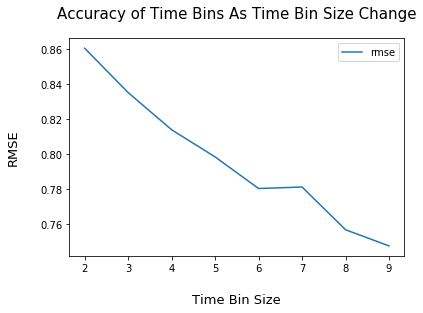

In [55]:
ax = x[['bin_size', 'rmse']].groupby('bin_size').mean().plot()
ax.set_xlabel("Time Bin Size", labelpad=20, fontsize=13)
ax.set_ylabel("RMSE", labelpad=20, fontsize=13)
ax.set_title("Accuracy of Time Bins As Time Bin Size Change", pad=20,fontsize=15)
plt.show()

#### Compare Bin Sizes Excluding Lucky Cases

In [36]:
x.loc[x['rmse'] > 0.70][['bin_size', 'rmse']].groupby('bin_size').mean()

,rmse
bin_size,
2,0.935272
3,0.927077
4,0.919056
5,0.921442
6,0.920990
7,0.938919
8,0.932482
9,0.957304


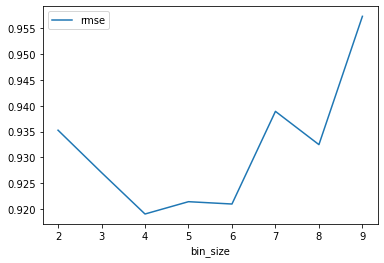

In [37]:
x.loc[x['rmse'] > 0.70][['bin_size', 'rmse']].groupby('bin_size').mean().plot()

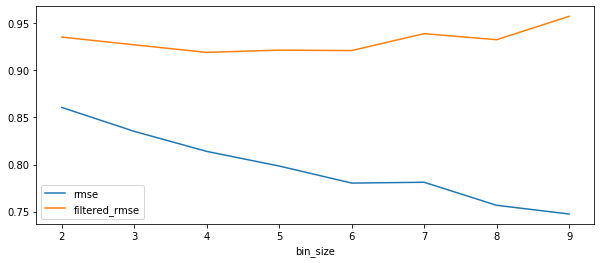

In [38]:
fig, ax = plt.subplots(figsize=(10,4))
x_filtered = x.loc[x['rmse'] > 0.70]
x_filtered.columns=['start_year','bin_size','filtered_rmse']
x[['bin_size', 'rmse']].groupby('bin_size').mean().plot(ax=ax)
x_filtered[['bin_size', 'filtered_rmse']].groupby('bin_size').mean().plot(ax=ax)
plt.show()

### Best Start Years of Bins

In [39]:
x[['rmse','start_year']].groupby(by='start_year').mean()

,rmse
start_year,
1996,0.736170
1997,0.802650
1998,0.792716
1999,0.783965
2000,0.789130
2001,0.805446
2002,0.786149
2003,0.762979
2004,0.792971


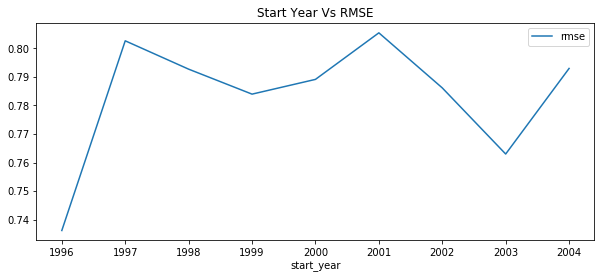

In [40]:
x[['rmse','start_year']].groupby(by='start_year').mean().plot(figsize=(10,4), title="Start Year Vs RMSE")
plt.show()

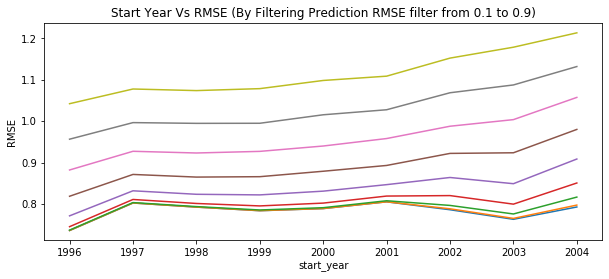

In [41]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Start Year")
ax.set_ylabel("RMSE")
x.loc[x['rmse'] > (0.1)][['rmse','start_year']].groupby(by='start_year').mean().plot(title="Start Year Vs RMSE (By Filtering Prediction RMSE filter from 0.1 to 0.9)",ax=ax,legend=False)
x.loc[x['rmse'] > (0.2)][['rmse','start_year']].groupby(by='start_year').mean().plot(ax=ax,legend=False)
x.loc[x['rmse'] > (0.3)][['rmse','start_year']].groupby(by='start_year').mean().plot(ax=ax,legend=False)
x.loc[x['rmse'] > (0.4)][['rmse','start_year']].groupby(by='start_year').mean().plot(ax=ax,legend=False)
x.loc[x['rmse'] > (0.5)][['rmse','start_year']].groupby(by='start_year').mean().plot(ax=ax,legend=False)
x.loc[x['rmse'] > (0.6)][['rmse','start_year']].groupby(by='start_year').mean().plot(ax=ax,legend=False)
x.loc[x['rmse'] > (0.7)][['rmse','start_year']].groupby(by='start_year').mean().plot(ax=ax,legend=False)
x.loc[x['rmse'] > (0.8)][['rmse','start_year']].groupby(by='start_year').mean().plot(ax=ax,legend=False)
x.loc[x['rmse'] > (0.9)][['rmse','start_year']].groupby(by='start_year').mean().plot(ax=ax,legend=False)
plt.show()

### RMSE of Bins as Years Pass By

In [ ]:
user_movie_matrix = movie_ratings.pivot_table(index='title', columns='user_id', values='rating')
return user_movie_matrix.corr(method="pearson", min_periods=min_common_elements)

In [93]:
data = x.groupby(['bin_size', 'start_year']).mean()

In [100]:
bin_size_start_year_matrix = data.pivot_table(index='start_year', columns='bin_size', values='rmse')

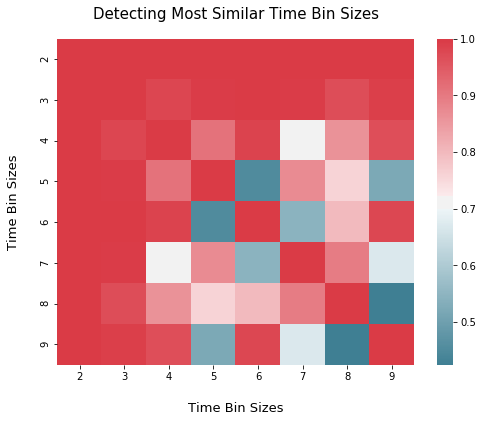

In [117]:
pearson_corrs_in_between_bins = bin_size_start_year_matrix.corr()
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(pearson_corrs_in_between_bins, ax=ax,xticklabels=pearson_corrs_in_between_bins.columns, yticklabels=pearson_corrs_in_between_bins.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))
ax.set_xlabel("Time Bin Sizes", labelpad=20, fontsize=13)
ax.set_ylabel("Time Bin Sizes", labelpad=20, fontsize=13)
ax.set_title("Detecting Most Similar Time Bin Sizes", pad=20,fontsize=15)
plt.show()

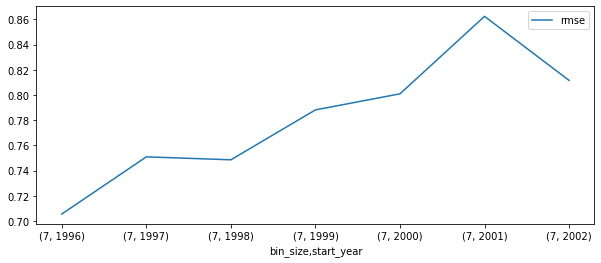

In [43]:
data[np.in1d(data.index.get_level_values(0), [7])].plot(figsize=(10,4))

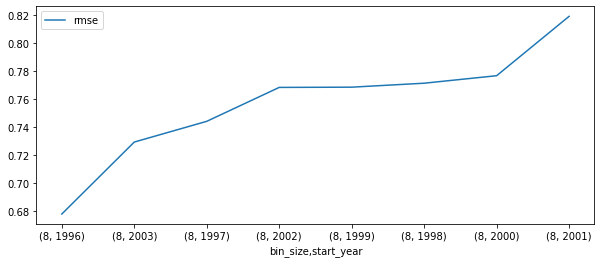

In [44]:
data[np.in1d(data.index.get_level_values(0), [8])].sort_values(by='rmse').plot(figsize=(10,4))

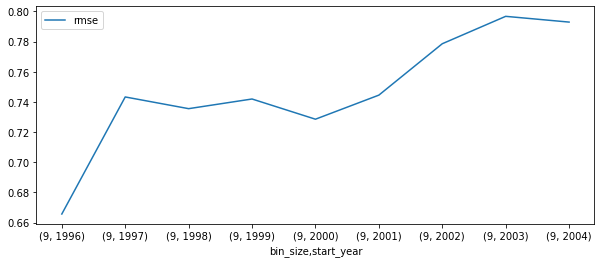

In [45]:
data[np.in1d(data.index.get_level_values(0), [9])].plot(figsize=(10,4))

# Plots on Best Year

### Max Number of Votes Taken Per Year

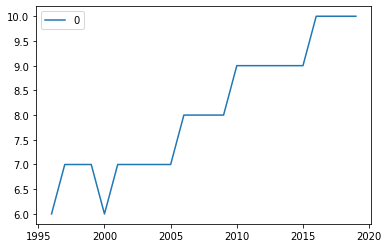

In [46]:
pd.DataFrame(best_year_df.max()).plot()

### Total Number of Votes Per Year

In [47]:
best_year_df

,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,3.0,...,2.0,4.0,4.0,3.0,4,4.0,3,5,9,10
1,NaN,1.0,1.0,NaN,1.0,2.0,2.0,3.0,2.0,3.0,...,5.0,5.0,5.0,5.0,5,6.0,9,9,8,10
2,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,...,4.0,4.0,4.0,4.0,4,5.0,7,9,10,10
3,4.0,4.0,5.0,3.0,3.0,7.0,5.0,6.0,5.0,5.0,...,7.0,7.0,6.0,7.0,7,7.0,8,8,8,10
4,4.0,4.0,4.0,4.0,3.0,6.0,5.0,5.0,6.0,5.0,...,6.0,6.0,5.0,6.0,6,6.0,7,10,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.0,4.0,4.0,4.0,3.0,3.0,4.0,4.0,3.0,5.0,...,4.0,4.0,4.0,4.0,5,5.0,6,7,6,10
996,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,5.0,5.0,5.0,5.0,5,6.0,8,8,7,10
997,2.0,2.0,3.0,2.0,3.0,3.0,3.0,4.0,3.0,4.0,...,4.0,5.0,4.0,6.0,6,7.0,8,9,9,10
998,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,4.0,...,4.0,5.0,4.0,6.0,6,6.0,8,8,7,10


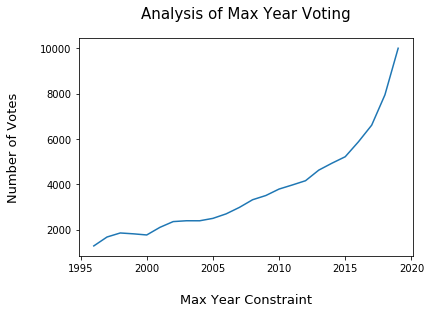

In [57]:
ax = pd.DataFrame(best_year_df.sum()).plot(legend=False)
ax.set_xlabel("Max Year Constraint", labelpad=20, fontsize=13)
ax.set_ylabel("Number of Votes", labelpad=20, fontsize=13)
ax.set_title("Analysis of Max Year Voting", pad=20,fontsize=15)
plt.show()

### Similarity of Year Votes

In [49]:
pearson_corrs_in_between_years = best_year_df.corr()

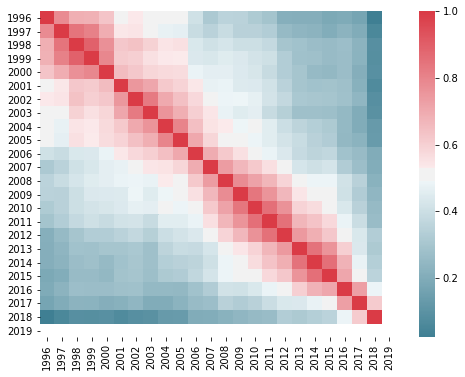

In [50]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(pearson_corrs_in_between_years, ax=ax,xticklabels=pearson_corrs_in_between_years.columns, yticklabels=pearson_corrs_in_between_years.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

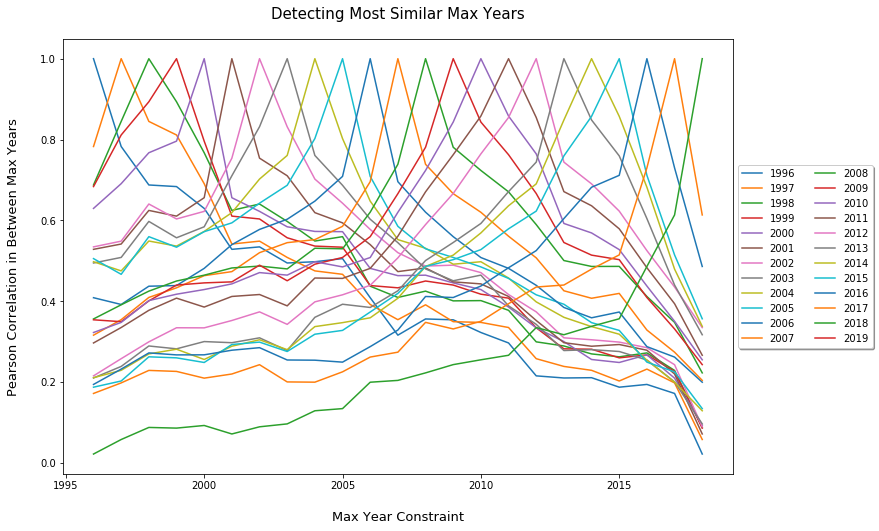

In [71]:
ax = best_year_df.corr().plot(figsize=(12,8))
ax.set_xlabel("Max Year Constraint", labelpad=20, fontsize=13)
ax.set_ylabel("Pearson Correlation in Between Max Years", labelpad=20, fontsize=13)
ax.set_title("Detecting Most Similar Max Years", pad=20,fontsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=2, fancybox=True, shadow=True)
plt.show()

### Density of Max Years

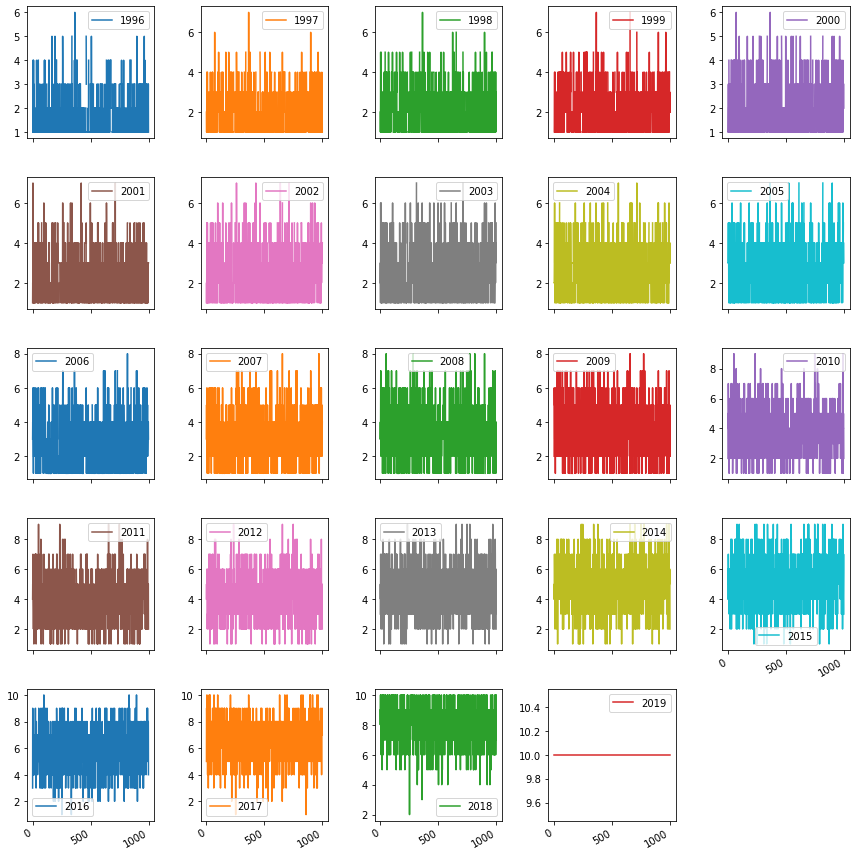

In [52]:
best_year_df.plot(subplots=True, layout=(5,5), figsize=(12,12))
plt.tight_layout()
plt.show()

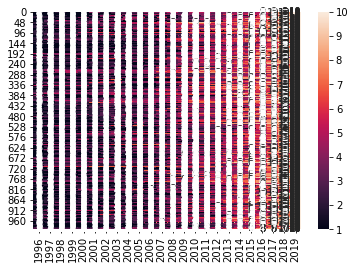

In [53]:
sns.heatmap(best_year_df, annot=True)